## Extracting the LSST-reprocessed Summer 2013 Stripe 82 photometry for a given object.  

We show the steps for an object SDSS J013007.13+002635.4 , a carbon star at [(ra,dec) = (22.529730609, 0.443172890)](http://skyserver.sdss.org/dr12/en/tools/explore/summary.aspx?ra=01+30+07.1&dec=00+26+35.4)



In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

### Figure out which path ... 

SDSS S82 is divided into patches labeled (I,J), with I index running along RA from right to left (with values 0:409), and J index running along DEC from bottom to top (with values 0 to 11). 

In [2]:
# finding patch in which desired object lays .
ra = 22.5297306
dec = 0.443172890
patch_bounds = pd.read_table('../raw_data/repo_fls/coaddBounds.txt', 
                             delim_whitespace=True)
mask_ra = (patch_bounds['maxRA'].values<ra)*(ra < patch_bounds['minRA'].values)
mask_dec = (patch_bounds['minDec'].values<dec)*(dec < patch_bounds['maxDec'].values)
mask = mask_ra * mask_dec
patch_bounds[mask]

,minRA,minDec,maxRA,maxDec,tract,patchI,patchJ,filePath
1778,22.56324,0.4163,22.33665,0.63268,0,307,8,"deepCoadd/r/0/307,8/coadd-r-0-307,8.fits"


Patches are aggregated along I index (as in ../packages/LC_processing.py ) : 

 NCSA : 
 
    ['00_21', '22_43','44_65', '66_87' ,'88_109','110_131',
    '132_153', '154_175',  '176_181', '365_387', '388_409'] 

  IN2P3 : 
    
    ['155_176', '176_197','197_218', '218_239', '239_260',
    '260_281', '281_302', '302_323','323_344', '344_365', '365_386']  

Thus given the I index we know in which of the above patch files we should look for photometry for that object. In our case patchI=307, so the photometry is in collection  302_323, processed at IN2P3

### Download the patch files from /astro/store/pogo4/ (if not already present)

This can be done with scp : 
    
    cd ~/GradResearch/SDSS_S82_FP_research/raw_data/rawDataFPSplit
    scp suberlak@epyc.astro.washington.edu:/astro/store/pogo4/s13_stripe82/forced_phot_lt_23/IN2P3/*302_323.csv.gz .

and  should take about 5 mins per tar file.

### Find out from DeepSource files what is the ra,dec per object

The DeepSource files contain 
    
    deepSourceId	parentDeepSourceId	deepCoaddId	ra	decl	psfMag	psfMagSigma	tract	patch	detect_is_primary

In [7]:
fname = '../raw_data/repo_fls/DeepSourceIN2P3_i_lt235_narrow.csv.gz'
ds = Table.read(fname,format='csv')

In [9]:
from astropy.table import hstack
from astropy.coordinates import SkyCoord
from astropy import units as u
# Use the SkyCoord  : express the coords of my object as 1-element catalog,
# find the best matches within the DeepSource catalog 
ra = 22.5297306
dec = 0.443172890
coord1 = SkyCoord(ra  = ra *u.degree, 
                  dec = dec*u.degree)
coord2 = SkyCoord(ra  = ds['ra']*u.degree, 
                  dec = ds['decl']*u.degree)
        

In [12]:
# Find nearest matches to coord1 in catalog coord2
idx, d2d, d3d = coord1.match_to_catalog_sky(coord2) 

In [20]:
# Print the row of DeepSource catalog 
# corresponding to that object 
objectId = ds[idx]['deepSourceId']
ds[idx]

deepSourceId,parentDeepSourceId,deepCoaddId,ra,decl,psfMag,psfMagSigma,tract,patch,detect_is_primary
int64,int64,int64,float64,float64,float64,float64,int64,str6,int64
2700409550411752,2700409550406756,20119619,22.5297397479,0.443172667135,17.2881431069,0.00974444156076,0,"307,8",1


Thus now we know that the deepSourceId is 2700409550411752 , which corresponds to objectId in the patches .

### Read in the  patch files

Here we read in all the files, select and extract photometry for that object (taking much code from processPatch2.py )  . The patch files contain 

    deepForcedSourceId	objectId	exposure_id	mjd	psfFlux	psfFluxErr

In [3]:
from astropy.table import Table
from astropy.table import vstack
from astropy.io import ascii
from astropy import version
version.version

'3.0.2'

In [74]:
# Read in chunks , and save only those rows that may correspond to that object :
DirIn = '../raw_data/rawDataFPSplit/'
p = '302_323'
# initialize storing results 
out_tbl_comb = Table()
for f in 'ugriz':
    print('Reading ',f,p)
    fname = DirIn + f+p+'.csv.gz'
    
    # set up an iterator over table chunks of 200 mb (no actual reading done yet)
    tbls = ascii.read(fname, format='csv', guess=False,
                      fast_reader={'chunk_size': 200*1000000,'chunk_generator':True})
    out_tbls = []
    # At this point the file is actually read in chunks.
    for tbl in tbls:
        # choose only rows with photometry for the given object 
        selected = tbl['objectId'] == objectId
        print('Adding ', np.sum(selected), ' rows')
        if np.count_nonzero(selected):
            tbl['filter'] = f
            out_tbls.append(tbl[selected])
    out_tbl = vstack(out_tbls)

    # Add the photometry from this filter to the overall table ... 
    out_tbl_comb = vstack([out_tbl, out_tbl_comb])

Reading  u 302_323
Adding  1811810  rows
Adding  1810306  rows
Adding  1812844  rows
Adding  1810861  rows
Adding  1809465  rows
Adding  1810545  rows
Adding  1811391  rows
Adding  1811760  rows
Adding  1811005  rows
Adding  1810546  rows
Adding  1811437  rows
Adding  1812963  rows
Adding  1811297  rows
Adding  1809409  rows
Reading  g 302_323
Adding  1809296  rows
Adding  1808649  rows
Adding  1808363  rows
Adding  1808541  rows
Adding  1808826  rows
Adding  1809134  rows
Adding  1808841  rows
Adding  1809178  rows
Adding  1809106  rows
Adding  1808273  rows
Adding  1808781  rows
Adding  1808592  rows
Adding  1808762  rows
Adding  1808280  rows
Adding  857925  rows
Reading  r 302_323
Adding  1811351  rows
Adding  1811439  rows
Adding  1811459  rows
Adding  1811835  rows
Adding  1811573  rows
Adding  1811217  rows
Adding  1810989  rows
Adding  1811411  rows
Adding  1811468  rows
Adding  1810470  rows
Adding  1810902  rows
Adding  1811013  rows
Adding  1810801  rows
Adding  1810779  row

In [75]:
# store the raw forced photometry 
out_tbl_comb.write('photometry_ugriz.txt', format='ascii', overwrite='True')

### Calculate magnitudes 

In [67]:
def flux2absigma(flux, fluxsigma):
    """Compute AB mag sigma given flux and flux sigma

    Here units of flux,  fluxsigma  don't matter 
    as long as they are consistent, since we are dividing 
    one by the other, so all the units cancel out.
    """
    FIVE_OVER_2LOG10 = 1.085736204758129569
    return FIVE_OVER_2LOG10 * fluxsigma / flux;


def flux2ab(flux, unit = 'Jy'):
    """Compute AB mag given flux. 

    Accept two unit types :  
    *  'cgs', meaning flux is in  ergs / s / Hz / cm2
    *  'Jy', meaning flux is in Jy.  1 Jy = 1E-23 * ergs/s/Hz/cm2
    """
    if unit == 'Jy':
        return -2.5 * np.log10(flux) + 8.90
    elif unit == 'cgs':
        return -2.5 * np.log10(flux) - 48.6

In [78]:
raw_data = out_tbl_comb
raw_data['psfFluxJy'] = raw_data['psfFlux'] * 1E23 
raw_data['psfFluxErrJy'] = raw_data['psfFluxErr'] * 1E23 
    
# 1.2  : drop all rows which have NaNs in psfFlux .... 
m1  = np.isnan(raw_data['psfFlux'].data)  # true if NaN 
 # true if not finite... 
m2 = np.bitwise_not(np.isfinite(raw_data['psfFlux'].data))  

 # logical or : true if either condition satisfied 
m = m1 | m2  
    
indices = np.arange(len(raw_data))
remove_rows= indices[m]
raw_data.remove_rows(remove_rows)

# calculate magnitudes 
raw_data['psfMag'] = flux2ab(raw_data['psfFluxJy'], unit='Jy')
raw_data['psfMagErr'] = flux2absigma(raw_data['psfFluxJy'], 
                                              raw_data['psfFluxErrJy'])

### Correct for extinction 

In [99]:
site = 'IN2P3'
DirEBV = '../raw_data/repo_fls/'
ebv_file = 'ebv_'+site+'_lt235.dat'
ebv = pd.read_table(DirEBV+ebv_file, delimiter=' ', usecols=[0,1])
ebv.columns = ['objectId','ebv']

# Find what is the EBV for this object 
object_ebv = ebv[ebv['objectId'].values == objectId]['ebv'].values[0]
print('E(B-V) is ', object_ebv)

E(B-V) is  0.0257108627942


In [130]:
# Correct for extinction 
A = [5.155, 3.793, 2.751, 2.086, 1.479]
filters = 'ugriz'
raw_data['psfMagDered'] = np.zeros(len(raw_data), dtype=float)

for i,f in enumerate(filters)  : 
    mask = raw_data['filter'] == f
    raw_data['psfMagDered'][mask] = raw_data['psfMag'][mask]+object_ebv * A[i]

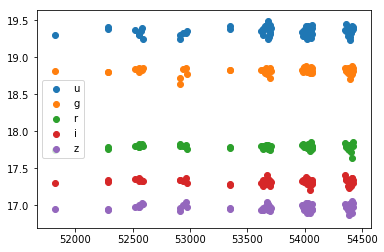

In [135]:
%matplotlib inline
for f in 'ugriz':
    mask = raw_data['filter'] == f
    plt.scatter(raw_data['mjd'][mask], raw_data['psfMagDered'][mask] , label=f)
plt.legend()

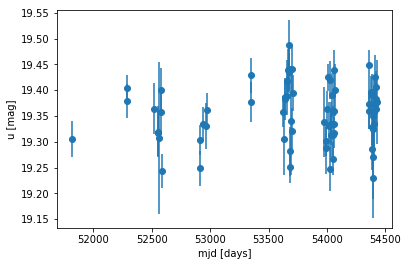

In [138]:
f = 'u'
mask = raw_data['filter'] == f
plt.errorbar(raw_data['mjd'][mask],raw_data['psfMagDered'][mask],
             raw_data['psfMagErr'][mask], fmt='o')
plt.xlabel('mjd [days]')
plt.ylabel(f +' [mag]')

In [139]:
# Save the data for J013007.13+002635.4
raw_data.write('photometry_ugriz_J013007.13+002635.4.txt', format='ascii')

In [146]:
# Example of file reading 
from astropy.table import Table
data = Table.read('photometry_ugriz_J013007.13+002635.4.txt', format='ascii')
mag,magerr, band = data['psfMagDered'], data['psfMagErr'], data['filter']
u,uErr = mag[band=='u'], magerr[band=='u']